In [1]:
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

import functools

from brax.training.agents.ppo import checkpoint as ppo_checkpoint

import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import mujoco
import numpy as np

import pandas as pd

Sun Mar  9 18:18:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:41:00.0 Off |                  Off |
| 36%   64C    P0             96W /  300W |    3823MiB /  49140MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from etils import epath

RESULTS_FOLDER_PATH = os.path.abspath('results')

# Sort by date and get the latest folder.
folders = sorted(os.listdir(RESULTS_FOLDER_PATH))
latest_folder = folders[-1]
print(f'Latest folder: {latest_folder}')

# In the latest folder, find the latest folder, ignore the files.
folders = sorted(os.listdir(epath.Path(RESULTS_FOLDER_PATH) / latest_folder))
folders = [f for f in folders if os.path.isdir(epath.Path(RESULTS_FOLDER_PATH) / latest_folder / f)]
latest_weights_folder = folders[-1]
print(f'Latest weights folder: {latest_weights_folder}')

policy_fn = ppo_checkpoint.load_policy(epath.Path(RESULTS_FOLDER_PATH) / latest_folder / latest_weights_folder)

Latest folder: 20250308-194411
Latest weights folder: 000151388160


/home/sorinal/miniconda3/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [3]:
from utils import draw_joystick_command
import time
import biped_berkeley as bb

env_name = bb.NAME_ROBOT
print(f'env_name: {env_name}')
env = bb.Biped()
eval_env = env

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
print(f'JITing reset and step')
jit_policy = jax.jit(policy_fn)
reset_fn = jax.jit(env.reset)
step_fn = jax.jit(env.step)

NAME_ROBOT: biped
env_name: biped
Number of joints: 10
JITing reset and step


In [4]:


rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 0.6  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.ctrl_dt * 1.5
phase = jp.array([0, jp.pi])

state = jit_reset(rng)
state.info["phase_dt"] = phase_dt
state.info["phase"] = phase

# create a df to store the state.metrics data
metrics_list = []
ctrl_list = []
for i in range(400):
  print(i)
  time_duration = time.time()
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_policy(state.obs, act_rng)
  ctrl_list.append(ctrl)
  state = jit_step(state, ctrl)
  metrics_list.append(state.metrics)
  if state.done:
    break
  state.info["command"] = command
  rollout.append(state)

  xyz = np.array(state.data.xpos[eval_env._mj_model.body("base_link").id])
  xyz += np.array([0, 0.0, 0])
  x_axis = state.data.xmat[eval_env._torso_body_id, 0]
  yaw = -np.arctan2(x_axis[1], x_axis[0])
  modify_scene_fns.append(
      functools.partial(
          draw_joystick_command,
          cmd=state.info["command"],
          xyz=xyz,
          theta=yaw,
          scl=np.linalg.norm(state.info["command"]),
      )
  )
  time_diff = time.time() - time_duration

render_every = 1
fps = 1.0 / eval_env.ctrl_dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)

media.show_video(frames, fps=fps, loop=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

100%|██████████| 400/400 [00:01<00:00, 297.92it/s]


In [5]:
ABS_FOLDER_RESUlTS = epath.Path(RESULTS_FOLDER_PATH) / latest_folder
media.write_video(f'{ABS_FOLDER_RESUlTS}/joystick_testing.mp4', frames, fps=fps)

In [17]:
# Save to csv metrics
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(ABS_FOLDER_RESUlTS / 'metrics.csv')

df = pd.read_csv(ABS_FOLDER_RESUlTS / 'metrics.csv', index_col=0)
PLOT_METRIC = False
if PLOT_METRIC == True:
    fig, ax = plt.subplots(11, 2, figsize=(10, 20), sharex=True)
    # plt.suptitle('Metrics for the {} environment'.format(env_name))
    for i, col in enumerate(df.columns):
        random_color = np.random.rand(3,)
        ax[i//2, i%2].plot(df[col], color=random_color, linewidth=2)
        ax[i//2, i%2].set_title(col)
    plt.tight_layout()
    for i in range(11):
        ax[i, 0].set_ylabel('Value')

    ax[10, 0].set_xlabel('Time step')
    ax[10, 1].set_xlabel('Time step')
    fig.savefig(ABS_FOLDER_RESUlTS / 'metrics.png')
    # plt.show()


              0            1            2            3            4  \
0    -0.1157055  -0.18084386  -0.92514664  -0.94035494  -0.33636248   
1  -0.013729214   -0.3942893  -0.95948935    -0.979077  -0.27570114   
2  -0.049497362  -0.41721877  -0.74953645  -0.08077862  -0.26972437   
3  0.0005496534    -0.386152   -0.4388675    0.2206157   -0.5601857   
4    0.08365915   -0.2607469  0.040795658   0.49143803  -0.53644854   

              5            6            7            8             9  
0   -0.14493105  -0.32830763   -0.8937638   -0.9222646    0.24144922  
1   -0.16411138   0.32339928  -0.90916616    -0.982589    0.45909035  
2  -0.104480825     0.644062  -0.33096126  -0.97333413     0.3409892  
3  -0.115660444    0.3973625    0.0574199  -0.91217554    0.23889874  
4   -0.17617474   0.10900652   0.07811208   -0.7021285  0.0015422502  
L_HAA


ValueError: setting an array element with a sequence.

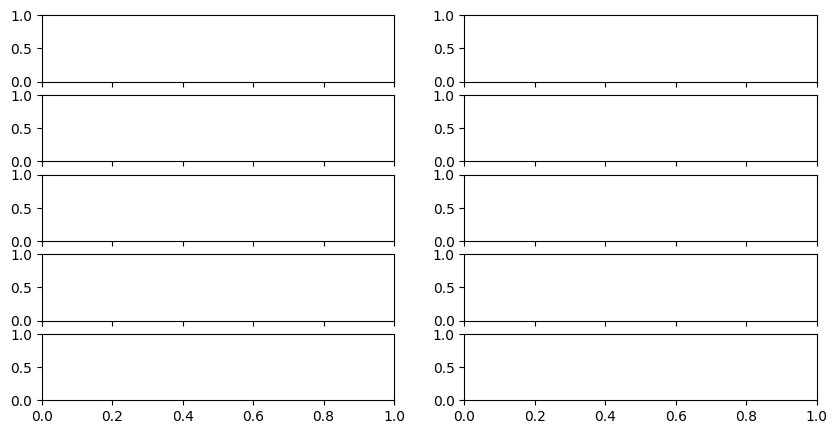

In [ ]:
ctrl_df = pd.DataFrame(ctrl_list)
ctrl_df.to_csv(ABS_FOLDER_RESUlTS / 'ctrl.csv')
print(ctrl_df.head())
col_names = ['L_HAA', 'L_HFE', 'L_KFE', 'L_ANKLE', 'R_HAA', 'R_HFE', 'R_KFE', 'R_ANKLE']
df = pd.read_csv(ABS_FOLDER_RESUlTS / 'ctrl.csv', names=col_names)
print(df.head())
fig, ax = plt.subplots(5, 2, figsize=(10, 5), sharex=True)

for i, col in enumerate(df.columns):
    random_color = np.random.rand(3,)
    print(col)
    ax[i//2, i%2].plot(df[col], color=random_color, linewidth=2)
    ax[i//2, i%2].set_title(col)

plt.tight_layout()
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend(df.columns)
plt.savefig(ABS_FOLDER_RESUlTS / 'ctrl.png')
plt.show()